In [1]:
from multi_unet_model import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import array_to_img

from keras.callbacks import ReduceLROnPlateau


In [3]:
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [4]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

In [22]:
train_images = []
train_masks = [] 
for element in os.listdir('../Unetdata/NewDatas/combinationAgri/data/train/image/'):
    element2=element.replace(".jpg", ".png")
    
    img = cv2.imread('../Unetdata/NewDatas/combinationAgri/data/train/image/'+str(element), 0)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)
    
    mask = cv2.imread('../Unetdata/NewDatas/combinationAgri/data/train/label/'+str(element2), 0)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
    train_masks.append(mask)
train_images = np.array(train_images)
train_masks = np.array(train_masks)


test_image_rgb = [] 
for element in os.listdir('../Unetdata/NewDatas/combinationAgri/data/test/image/'):
    img = cv2.imread('../Unetdata/NewDatas/combinationAgri/data/test/image/'+str(element), 0)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    test_image_rgb.append(img)
    
test_images = []
test_masks = [] 
for element in os.listdir('../Unetdata/NewDatas/combinationAgri/data/test/image/'):
    element2=element.replace(".jpg", ".png")
    
    img = cv2.imread('../Unetdata/NewDatas/combinationAgri/data/test/image/'+str(element), 0)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    test_images.append(img)
    
    mask = cv2.imread('../Unetdata/NewDatas/combinationAgri/data/test/label/'+str(element2), 0)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
    test_masks.append(mask)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [11]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("../Unetdata/NewDatas/combinationAgri/data/train/image/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [60]:
print(test_images.shape)

(61, 256, 256)


In [12]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("../Unetdata/NewDatas/combinationAgri/data/train/label/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [6]:
print(train_masks.shape)
print(np.unique(train_masks))

(241, 256, 256)
[  0 100 201]


In [7]:
plt.imshow(train_images[14, :,:,0])
plt.imshow(train_masks[14])

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [23]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

np.unique(test_masks_encoded_original_shape)

array([0, 1, 2])

In [24]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


test_images = np.expand_dims(test_images, axis=3)
test_images = normalize(test_images, axis=1)

test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

In [110]:
print(test_masks_input.shape)

(61, 256, 256, 1)


In [25]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_val, y1, y_val = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)



In [26]:
y_train = y1
X_train = X1

In [ ]:
X_train

In [15]:
print(X_test.shape)

(25, 256, 256, 1)


In [27]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

test_masks_cat = to_categorical(test_masks_input, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((test_masks_input.shape[0], test_masks_input.shape[1], test_masks_input.shape[2], n_classes))
X_test = test_images 

In [107]:
print(y_test.shape)

(25, 256, 256, 1)


In [28]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)



Class weights are...: [ 0.34652761 13.55392848 24.72328822]


In [12]:
class_weights = [0.0,13.55392848,24.72328822]

In [37]:
class_weights = np.array([0.34653484,13.54392121,24.71980567])

In [17]:
sample_weights = np.zeros((216,65536,3))
sample_weights[:, 0] += 0.34653484
sample_weights[:, 1] += 13.54392121
sample_weights[:, 2] += 24.71980567

In [18]:
sample_weights = np.squeeze(np.sum(sample_weights, axis=-1))

In [19]:
sample_weights.shape

(216, 65536)

In [28]:
class_weights = np.zeros((65536, 3))
class_weights[:, 0] += 0.34652761 
class_weights[:, 1] += 13.55392848 
class_weights[:, 2] += 24.72328822


In [29]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [13]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index 
        one64= np.ones(1, dtype=np.int64)
        classSelectors = [K.equal(one64[0]*i, classSelectors) for i in range(len(weightsList))]
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [30]:

with tf.device('/GPU:1'):
    def get_model():
        return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
model.compile(loss= weightedLoss(keras.losses.categorical_crossentropy, weights), 
              optimizer=..., ...)

In [15]:
import keras
from keras import backend as K

In [31]:
with tf.device('/GPU:1'):
    model = get_model()
    #model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=0.001), loss=weightedLoss(keras.losses.categorical_crossentropy, class_weights), metrics=['accuracy'])
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [26]:
print(y_train_cat.shape)
new_train = np.zeros([216,256*256,3])
for i in range (216):
    new_train[i,:,0]=y_train_cat[i,:,:,0].reshape(-1)
    new_train[i,:,1]=y_train_cat[i,:,:,1].reshape(-1)
    new_train[i,:,2]=y_train_cat[i,:,:,2].reshape(-1)

(216, 256, 256, 3)


In [24]:
new_train= y_train_cat.reshape(-1)


In [27]:
new_train.shape

(216, 65536, 3)

In [29]:
print(y_test_cat.shape)
new_test = np.zeros([25,256*256,3])
for i in range (25):
    new_test[i,:,0]=y_test_cat[i,:,:,0].reshape(-1)
    new_test[i,:,1]=y_test_cat[i,:,:,1].reshape(-1)
    new_test[i,:,2]=y_test_cat[i,:,:,2].reshape(-1)

(25, 256, 256, 3)


In [ ]:
print(y_test_cat.shape)
new_val = np.zeros([25,256*256,3])
for i in range (25):
    new_test[i,:,0]=y_test_cat[i,:,:,0].flatten()
    new_test[i,:,1]=y_test_cat[i,:,:,1].flatten()
    new_test[i,:,2]=y_test_cat[i,:,:,2].flatten()

In [19]:
print(y_train_cat.shape)

(216, 256, 256, 3)


In [18]:
#print(new_train)
print(y_train)

[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]

In [48]:
with tf.device('/GPU:1'):
    model_checkpoint = [ReduceLROnPlateau(monitor = 'val_loss', 
                            factor = 0.6, 
                            patience = 30, 
                            min_lr=0.0000001, 
                            verbose=1, 
                            mode='max'),ModelCheckpoint('TrueUnetCombi.hdf5',
                          monitor='val_accuracy',
                          save_best_only=True, 
                          verbose=1,                       
                          mode='max')]
   
    history = model.fit(X_train, y_train_cat, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=1000, 
                    validation_data=(X_val, y_val_cat), 
                    #sample_weight=sample_weights,
                    shuffle=True,
                    callbacks=[model_checkpoint])

Epoch 1/1000
54/54 [==============================] - 2s 30ms/step - loss: 2.0847 - accuracy: 0.9471 - val_loss: 1.1909 - val_accuracy: 0.9540

Epoch 00001: val_accuracy improved from -inf to 0.95405, saving model to TrueUnetCombi.hdf5
Epoch 2/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.9788 - accuracy: 0.9664 - val_loss: 1.2644 - val_accuracy: 0.9540

Epoch 00002: val_accuracy did not improve from 0.95405
Epoch 3/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.9957 - accuracy: 0.9630 - val_loss: 1.0491 - val_accuracy: 0.9540

Epoch 00003: val_accuracy did not improve from 0.95405
Epoch 4/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.8830 - accuracy: 0.9634 - val_loss: 0.9998 - val_accuracy: 0.9540

Epoch 00004: val_accuracy did not improve from 0.95405
Epoch 5/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.8910 - accuracy: 0.9589 - val_loss: 0.8700 - val_accuracy: 0.9540

Epoch 00005: val_accura

54/54 [==============================] - 1s 26ms/step - loss: 0.5150 - accuracy: 0.9632 - val_loss: 0.6568 - val_accuracy: 0.9557

Epoch 00041: val_accuracy did not improve from 0.95970
Epoch 42/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.4494 - accuracy: 0.9704 - val_loss: 0.5578 - val_accuracy: 0.9624

Epoch 00042: val_accuracy improved from 0.95970 to 0.96245, saving model to TrueUnetCombi.hdf5
Epoch 43/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.5045 - accuracy: 0.9647 - val_loss: 0.6691 - val_accuracy: 0.9554

Epoch 00043: val_accuracy did not improve from 0.96245
Epoch 44/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.4466 - accuracy: 0.9686 - val_loss: 0.6400 - val_accuracy: 0.9576

Epoch 00044: val_accuracy did not improve from 0.96245
Epoch 45/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.4418 - accuracy: 0.9690 - val_loss: 0.5563 - val_accuracy: 0.9610

Epoch 00045: val_accuracy did

54/54 [==============================] - 1s 26ms/step - loss: 0.1391 - accuracy: 0.9877 - val_loss: 0.8232 - val_accuracy: 0.9683

Epoch 00120: val_accuracy did not improve from 0.96863
Epoch 121/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1147 - accuracy: 0.9898 - val_loss: 0.8263 - val_accuracy: 0.9682

Epoch 00121: val_accuracy did not improve from 0.96863
Epoch 122/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1177 - accuracy: 0.9896 - val_loss: 0.9040 - val_accuracy: 0.9686

Epoch 00122: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.

Epoch 00122: val_accuracy did not improve from 0.96863
Epoch 123/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1261 - accuracy: 0.9888 - val_loss: 0.8799 - val_accuracy: 0.9685

Epoch 00123: val_accuracy did not improve from 0.96863
Epoch 124/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1249 - accuracy: 0.9890 - val_loss: 0.9139 - val_a


Epoch 00159: val_accuracy did not improve from 0.96914
Epoch 160/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1111 - accuracy: 0.9901 - val_loss: 1.0029 - val_accuracy: 0.9683

Epoch 00160: val_accuracy did not improve from 0.96914
Epoch 161/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1018 - accuracy: 0.9908 - val_loss: 1.0000 - val_accuracy: 0.9686

Epoch 00161: val_accuracy did not improve from 0.96914
Epoch 162/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.0978 - accuracy: 0.9913 - val_loss: 1.0436 - val_accuracy: 0.9681

Epoch 00162: val_accuracy did not improve from 0.96914
Epoch 163/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.0917 - accuracy: 0.9918 - val_loss: 0.9707 - val_accuracy: 0.9684

Epoch 00163: val_accuracy did not improve from 0.96914
Epoch 164/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.1019 - accuracy: 0.9910 - val_loss: 1.0028 - val_accuracy: 0.

54/54 [==============================] - 1s 26ms/step - loss: 0.0893 - accuracy: 0.9920 - val_loss: 1.1071 - val_accuracy: 0.9681

Epoch 00200: val_accuracy did not improve from 0.96914
Epoch 201/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.0894 - accuracy: 0.9921 - val_loss: 1.1038 - val_accuracy: 0.9679

Epoch 00201: val_accuracy did not improve from 0.96914
Epoch 202/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.0946 - accuracy: 0.9917 - val_loss: 1.1242 - val_accuracy: 0.9678

Epoch 00202: val_accuracy did not improve from 0.96914
Epoch 203/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.0931 - accuracy: 0.9917 - val_loss: 1.1103 - val_accuracy: 0.9678

Epoch 00203: val_accuracy did not improve from 0.96914
Epoch 204/1000
54/54 [==============================] - 1s 26ms/step - loss: 0.0802 - accuracy: 0.9929 - val_loss: 1.1042 - val_accuracy: 0.9679

Epoch 00204: val_accuracy did not improve from 0.96914
Epoch 205/

KeyboardInterrupt: 

In [22]:
with tf.device('/GPU:1'):model.save('test.hdf5')

In [32]:
model.load_weights('AgriUnetCombi.hdf5')

In [33]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 0s 50ms/step - loss: 0.8817 - accuracy: 0.9735
Accuracy is =  97.19458222389221 %


In [35]:
len(X_test)

61

In [81]:
for x in range(len(y_pred_argmax)):
    for i in range(255):
        for j in range(255):
            if test_masks_input[x,i,j,0] != 0 and test_masks_input[x,i,j,0] != 1 and test_masks_input[x,i,j,0] != 2:
                print(test_masks_input[x,i,j,0])

In [34]:
from keras.metrics import MeanIoU
n_classes = 3
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
f = open('../UnetAgriCombination.csv', "w")
ligne="img,class1 IoU, class2 IoU, class3 IoU, m1, m2, m3 ,p1, p2, p3"
ligne = ligne+'\r\n'
f.write(ligne)
ligne=""

for x in range(len(X_test)):
    m1=0
    m2=0
    m3=0
    p1=0
    p2=0
    p3=0
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(test_masks_input[x,:,:,0], y_pred_argmax[x])
    print("Mean IoU =", IOU_keras.result().numpy())
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    #print(values)
    class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2]  + values[1,0]+ values[2,0])
    class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2]  + values[0,1]+ values[2,1])
    class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1]  + values[0,2]+ values[1,2])

    print("IoU for class1 is: ", class1_IoU)
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    ligne=ligne+str(x)+","+str(class1_IoU)+","+str(class2_IoU)+","+str(class3_IoU)+","
    for i in range(255):
        for j in range(255):
            if test_masks_input[x,i,j,0] == 0:
                m1+=1
            elif test_masks_input[x,i,j,0] == 1:
                m2+=1
            elif test_masks_input[x,i,j,0] == 2:
                m3+=1
            if y_pred_argmax[x,i,j] == 0:
                p1+=1
            elif y_pred_argmax[x,i,j] == 1:
                p2+=1
            elif y_pred_argmax[x,i,j] == 2:
                p3+=1
    ligne = ligne+str(m1)+','+str(m2)+','+str(m3)+','+str(p1)+','+str(p2)+','+str(p3)
    ligne = ligne+'\r\n'
    f.write(ligne)
    ligne=""

f.close()

Mean IoU = 0.3850433
IoU for class1 is:  0.9261748105647198
IoU for class2 is:  0.22895512610547003
IoU for class3 is:  0.0
Mean IoU = 0.3311151
IoU for class1 is:  0.9933452386403528
IoU for class2 is:  0.0
IoU for class3 is:  0.0
Mean IoU = 0.4877306
IoU for class1 is:  0.9273587254169778
IoU for class2 is:  0.0
IoU for class3 is:  0.5358329871208973
Mean IoU = 0.3354976
IoU for class1 is:  0.9657506846785857
IoU for class2 is:  0.04074208803201164
IoU for class3 is:  0.0
Mean IoU = 0.6594107
IoU for class1 is:  0.9825590345124843
IoU for class2 is:  0.3362624487404804
IoU for class3 is:  nan


/home/cybercomml/anaconda3/envs/nathanenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


Mean IoU = 0.4971466
IoU for class1 is:  0.994293212890625
IoU for class2 is:  0.0
IoU for class3 is:  nan
Mean IoU = 0.62745523
IoU for class1 is:  0.9970979074385214
IoU for class2 is:  0.2578125
IoU for class3 is:  nan
Mean IoU = 0.37075102
IoU for class1 is:  0.985142000244828
IoU for class2 is:  0.12711111111111112
IoU for class3 is:  0.0
Mean IoU = 0.52049106
IoU for class1 is:  0.9816070882981974
IoU for class2 is:  0.059375
IoU for class3 is:  nan
Mean IoU = 0.49949646
IoU for class1 is:  0.998992919921875
IoU for class2 is:  0.0
IoU for class3 is:  nan
Mean IoU = 0.49243927
IoU for class1 is:  0.9848785400390625
IoU for class2 is:  0.0
IoU for class3 is:  nan
Mean IoU = 0.4894333
IoU for class1 is:  0.9788665771484375
IoU for class2 is:  0.0
IoU for class3 is:  nan
Mean IoU = 0.5064846
IoU for class1 is:  0.9768017226897173
IoU for class2 is:  0.03616751269035533
IoU for class3 is:  nan
Mean IoU = 0.38745704
IoU for class1 is:  0.9883014933611358
IoU for class2 is:  0.0
IoU fo

In [51]:
#model = get_model()
#model.load_weights('test.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [105]:
y_val_cat[:,:,:,0].shape

(25, 256, 256)

In [52]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_masks_input[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())




Mean IoU = 0.4745451


In [53]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2]  + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2]  + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1]  + values[0,2]+ values[1,2])
#class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)



[[3.842605e+06 1.844300e+04 1.060300e+04]
 [5.651000e+04 2.302300e+04 2.558000e+03]
 [2.798800e+04 2.850000e+03 1.311600e+04]]
IoU for class1 is:  0.9712993620816607
IoU for class2 is:  0.2226940338930589
IoU for class3 is:  0.2296419504508448


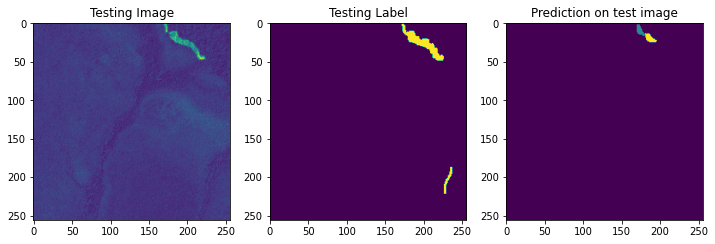

In [76]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_rgb[10])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_masks[10,:,:])

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_argmax[10])
plt.show()

In [55]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

NameError: name 'y_test' is not defined